In [6]:
import pickle
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from ann import ANNRegressor_model
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.ensemble import GradientBoostingRegressor 

sns.set(style='whitegrid')

# Update model process

1. **Step 1** - Load the new training dataset and perform preprocessing and feature engineering. Note that the previously saved selected features/ attributes are not used in the retraining process.

2. **Step 2** - Perform feature selection with gradient boosting based on the dataset and select the updated important features.

3. **Step 3** - Standardize the preprocessed dataset with the updated important features.

3. **Step 3** - Reconstruct the ANN regressor model and retrain/ refit it with the dataset. In the updating process, there are two scenarios to be considered in setting the trainable layers:
    * If the dataset is small, the first two layers are non-trainable, it is to make the model generalized enough to capture patterns across different small dataset but also finetuned to the most up-to-date dataset. 
    * If the dataset is large, all the layers are trainable since the large dataset might contain pattern that has not been seen by the model before. To make the training time faster, only 50% of the dataset is randomly sampled.

4. **Step 4** - Save the updated selected important features and scalers

**Function - Preprocess & feature engineering**

In [7]:
# Set the parameter 'training' to True if the label exists

def preprocess_featureengineering(df, training):
    
    # Identify and handle null items
    if training: # The label is only available in training
        idx_null = np.where(df['Delivery Time (days)'].isnull()==1)[0]
        df.drop(idx_null, axis=0, inplace=True) # Remove the samples without the labels
        df.reset_index(drop=True, inplace=True) # Reset index
    df.fillna('0', inplace=True) # Fill null item with '0' for attribute 'Order Type'
    
    # Feature engineering with attribute 'Order Create Date'
    df['Month'] = df['Order Create Date'].apply(lambda x: x.month)
    df['Day'] = df['Order Create Date'].apply(lambda x: x.day)
    df['Weekend'] = df['Order Create Date'].apply(lambda x: 1 if x.weekday() >=5 else 0)    
    
    # Remove the unwanted columns
    columns_to_remove = ['Customer Expected Delivery Date', 'Order ID', 'Product Center', 
                         'Product Sub Center', 'Customer Name', 'Order Type', 
                         'Order Create Date', 'Product ID']
    df.drop(columns_to_remove, axis=1, inplace=True)
    
    # One hot encode categorical attributes
    columns_categorical = ['Delivery Priority Code', 'Product Shipping Point', 
                           'Product Supplier', 'Product Type', 'Month', 
                           'Day', 'Weekend']
    df = pd.get_dummies(df, columns=columns_categorical, drop_first=True)
    
    return df

**Function - Select features with gradient boosting regressor**

In [8]:
def feature_selection(df):  
    
    def plot_feature_importance(model, features):
        
        # Select the top 25 features
        num_features = 25
        importance = model.feature_importances_/sum(model.feature_importances_)
        idx = np.argsort(importance)[::-1][:num_features]
        
        fig, ax1 = plt.subplots(figsize=(15, 5))

        # Primary axis
        ax1.bar(x = np.arange(0, num_features), height = importance[idx])
        ax1.set_xticks(ticks = np.arange(0, num_features))
        ax1.set_xticklabels(features[idx], rotation = 90) #, rotation_mode="anchor")
        ax1.set_xlabel("Features")
        ax1.set_ylabel("Importance")
        ax1.set_title('Importance of Respective Features')

        # Secondary axis
        ax2 = ax1.twinx()
        ax2.plot(np.cumsum(importance[idx]), 'ro-')
        ax2.set_ylabel("Accumulative Importance")
        plt.show()

        return features[idx]

    y = df['Delivery Time (days)']
    x = df.drop('Delivery Time (days)', axis=1, inplace=False)

    GBR = GradientBoostingRegressor(loss = "huber", learning_rate = 0.1, n_estimators = 100, 
                                   subsample = 1.0, max_features = 1.0, min_samples_split = 2, 
                                   min_samples_leaf = 1, verbose = 0, validation_fraction=0.1)
    GBR.fit(x.values, y)
    selected_features = plot_feature_importance(GBR, x.columns)
    
    return selected_features

**Function - Retraining pipeline**

In [9]:
# Set the parameter 'training' to True if the label exists

def retraining_pipeline(df, training):
    
    print ('Retraining starts...')
    df = preprocess_featureengineering(df, training)
    print ('\n')
    
    df = df.sample(frac=0.5)
    
    # Feature selection
    print ('Reselecting important features...')
    selected_features = feature_selection(df)
    print ('\n')
    
    # Standardization of delivery time and order product quantity
    print ('Standardizing...')
    quantity_scaler = StandardScaler( with_mean=True, with_std=True)
    deliverytime_scaler = StandardScaler( with_mean=True, with_std=True) 
    x_categorical = df[selected_features].drop('Order Product Quantity', axis=1, inplace=False).values
    x_numerical = df['Order Product Quantity'].values
    x_numerical = quantity_scaler.fit_transform(np.expand_dims(x_numerical, axis=1))
    x_train = np.concatenate((x_categorical, x_numerical), axis=1)
    if training:
        y = df['Delivery Time (days)']
        y_train = deliverytime_scaler.fit_transform(np.expand_dims(y, axis=1))
    print ('\n')
        
    # Retraining of the model
    # Load the model parameters and initialization of ANN regressor model
    print ('Retraining the ANN regressor model...')
    with open('parameters.pkl', 'rb') as file:
        units, num_features, file_dir, epochs, batch_size, quantile = pickle.load(file)
        
    model = ANNRegressor_model(units, num_features, quantile, 
                               file_dir, epochs, batch_size,
                               deliverytime_scaler)
    
    # Set trainable and non-trainable layer
    model.refit_model(x_train, y_train)
    mae, percentage_delayed_delivery = model.evaluate(x_train, y_train, False)
    print ('\n')

    print ('Saving the updated selected features and scalers...')
    # Save the updated selected important features/ attributes & scalers
    with open('selected_features.pkl', 'wb') as file:
        pickle.dump(selected_features, file)
    with open('quantity_scaler.pkl', 'wb') as file:
        pickle.dump(quantity_scaler, file)
    with open('deliverytime_scaler.pkl', 'wb') as file:
        pickle.dump(deliverytime_scaler, file)
    print ('\n')
    
    print ('Retraining completes...')

**Main**

Retraining starts...


Reselecting important features...


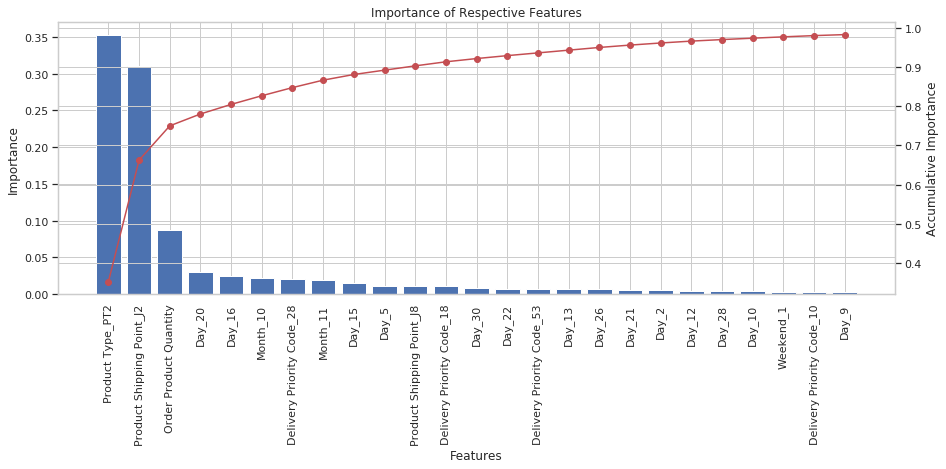



Standardizing...


Retraining the ANN regressor model...
Layer 0 set non-trainable
Layer 1 set non-trainable
The mean absolute error: 0.93 days
The percentage of delayed delivery: 10.77%


Saving the updated selected features and scalers...


Retraining completes...


In [10]:
if __name__ == '__main__':
    
    # Read file and preprocess & feature engineer
    df = pd.read_excel('data_train.xlsx')
    
    # Set the parameter 'training' to True if the label exists
    training = True
    
    # Execution pipeline
    retraining_pipeline(df, training)